In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read the CSV file
df = pd.read_csv('ANON36_MACE_EKG_output.csv')

# change variable names
df = df.rename(columns={
    'Risk- Hypertension' : 'Hypertension',
    'Risk- Hypercholesteremia' : 'Hypercholesteremia', 
    'Risk- Hypertriglyceridemia' : 'Hypertriglyceridemia',
    'Risk- High HDL' : 'High HDL', 
    'Risk- Low HDL' : 'Low HDL', 
    'Risk- Diabetes' : 'Diabetes', 
    'Risk- Family Hx' : 'Family Hx',
    'Risk- Smoke' : 'Smoke', 
    'ASCVD PCE Risk Score' :'ASCVD PCE Risk',
    'PREVENT Score - ASCVD 10-year risk' : 'PREVENT ASCVD Risk', 
    'CVD PREVENT 10yr' : 'PREVENT CVD Risk',
    'HF PREVENT 10-year' : 'PREVENT HF Risk', 
    'Total A' : 'Total CAC Score', 
    'LM A' : 'CAC Score (Left Main)', 
    'LAD A' : 'CAC Score (LAD)', 
    'Cx' : 'CAC Score (LCx)', 
    'RCA' : 'CAC Score (RCA)',
    'Num Lesions' : 'Number of Total Lesions', 
    'Lesion Vol Sum' : 'Total Volume Score', 
    'Lesion Max D' : 'Peak CAC Density', 
    'Lesion Ave D' : 'Mean CAC Density', 
    'Male' : 'Gender',
    'Race_encoded' : 'Race',
})

In [4]:
# Select the columns
X = df.drop(['CONFIRM ID', 'result'], axis=1)
y = df['result']

# Make some columns categorical
categorical_cols = [X.columns[i] for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,45]]
for col in categorical_cols:
    X[col] = X[col].astype('category')

In [5]:
# Initialize StratifiedKFold for 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

# Create the XGBClassifier
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

# Placeholder for the stacked probabilities
stacked_probabilities = np.zeros(y.shape)

# List to hold AUC scores for each fold
auc_scores = []

# Cross-validation loop
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    stacked_probabilities[test_index] = y_pred_proba
    
    # Calculate AUC for the current fold
    fold_auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(fold_auc)

Plot calibration curve

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y, stacked_probabilities, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
plt.plot([0,1], [0,1], linestyle="--", color="black", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()


Plot the ROC curve

Final AUC-ROC: 0.7550651223033389


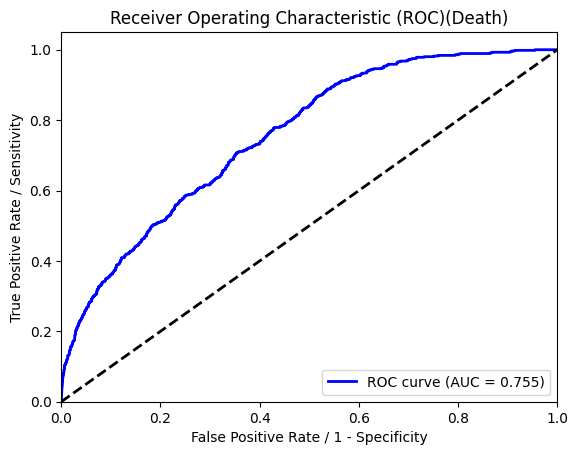

In [6]:
# Final evaluation
final_auc = roc_auc_score(y, stacked_probabilities)
print(f"Final AUC-ROC: {final_auc}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y, stacked_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / 1 - Specificity')
plt.ylabel('True Positive Rate / Sensitivity')
plt.title('Receiver Operating Characteristic (ROC)(Death)')
plt.legend(loc="lower right")
plt.show()

Try to find Cutoffs:

In [8]:
# Create a DataFrame with actual outcomes and predicted probabilities
output_df = pd.DataFrame({
    'Actual Outcome': y,  # Real outcome (0 or 1)
    'Predicted Probability': stacked_probabilities  # Probability of class 1
})

# Save the DataFrame to a CSV file
# output_df.to_csv('predicted_probabilities_with_actuals.csv', index=False)

# Display the first few rows
print(output_df.head())

   Actual Outcome  Predicted Probability
0               0               0.000083
1               0               0.013772
2               0               0.000568
3               0               0.015657
4               0               0.000332


Loops through combinations of percentiles to determine optimal cutoff values for risk stratification based on predicted probabilities. 

For each pair of cutoffs:

The population is divided into Low, Moderate, and High Risk groups.

It calculates:

The number of samples and number of events in each group.

The event rate (%) within each group.

The ROC AUC score within each group (if there are enough samples).

A weighted average AUC across groups, based on sample sizes.

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import display

# Store results in a list
cutoff_results = []

# Try different cut-offs from 5th to 95th percentile
for p1 in range(5, 50, 5):  # Low risk cut-off
    for p2 in range(50, 95, 5):  # High risk cut-off
        if p1 >= p2:
            continue  # Ensure valid cutoffs
        
        temp_cutoffs = np.percentile(output_df['Predicted Probability'], [p1, p2])

        # Assign new risk groups
        output_df['Temp Risk Group'] = output_df['Predicted Probability'].apply(
            lambda prob: "Low Risk" if prob < temp_cutoffs[0] else ("Moderate Risk" if prob < temp_cutoffs[1] else "High Risk")
        )

        # Count the number of samples in each risk group
        group_counts = output_df['Temp Risk Group'].value_counts().to_dict()

        # Count events (y=1) in each risk group
        event_counts = output_df.groupby('Temp Risk Group')['Actual Outcome'].sum().to_dict()

        # Compute event percentage WITHIN each risk group
        event_percentages = {
            group: (event_counts.get(group, 0) / group_counts.get(group, 1)) * 100  
            for group in ["Low Risk", "Moderate Risk", "High Risk"]
        }

        # Compute AUC within each group
        auc_per_group = {}
        for group in ["Low Risk", "Moderate Risk", "High Risk"]:
            group_df = output_df[output_df['Temp Risk Group'] == group]
            if len(group_df) > 50:  # Only calculate AUC if there are enough cases
                auc_per_group[group] = roc_auc_score(group_df['Actual Outcome'], group_df['Predicted Probability'])
            else:
                auc_per_group[group] = None  # Not enough data

        # Compute weighted average AUC (Weighted AUC)
        valid_aucs = {group: auc for group, auc in auc_per_group.items() if auc is not None}
        total_samples = sum(group_counts.values())

        if valid_aucs and total_samples > 0:
            weighted_auc = sum(
                (group_counts[group] * auc_per_group[group]) for group in valid_aucs.keys()
            ) / total_samples
        else:
            weighted_auc = None

        # Store results
        cutoff_results.append({
            "Low Cutoff Percentile": p1,
            "High Cutoff Percentile": p2,
            
            "Low Risk AUC": auc_per_group["Low Risk"],
            "Low Risk Count": group_counts.get("Low Risk", 0), 
            "Low Risk Event Count": event_counts.get("Low Risk", 0),
            "Low Risk Event %": event_percentages.get("Low Risk", 0), 

            "Moderate Risk AUC": auc_per_group["Moderate Risk"],
            "Moderate Risk Count": group_counts.get("Moderate Risk", 0),  
            "Moderate Risk Event Count": event_counts.get("Moderate Risk", 0),  
            "Moderate Risk Event %": event_percentages.get("Moderate Risk", 0),  

            "High Risk AUC": auc_per_group["High Risk"],
            "High Risk Count": group_counts.get("High Risk", 0),  
            "High Risk Event Count": event_counts.get("High Risk", 0),  
            "High Risk Event %": event_percentages.get("High Risk", 0),  

            "Weighted AUC": weighted_auc  
        })

# Convert results to a DataFrame for analysis
cutoff_results_df = pd.DataFrame(cutoff_results)

# Display the results
display(cutoff_results_df)


,Low Cutoff Percentile,High Cutoff Percentile,Low Risk AUC,Low Risk Count,Low Risk Event Count,Low Risk Event %,Moderate Risk AUC,Moderate Risk Count,Moderate Risk Event Count,Moderate Risk Event %,High Risk AUC,High Risk Count,High Risk Event Count,High Risk Event %,Weighted AUC
0,5,50,0.883824,1361,1,0.073475,0.746277,12243,91,0.743282,0.650668,13604,465,3.418112,0.705353
1,5,55,0.883824,1361,1,0.073475,0.738711,13603,120,0.882158,0.656041,12244,436,3.560928,0.708767
2,5,60,0.883824,1361,1,0.073475,0.728146,14964,149,0.995723,0.660042,10883,407,3.739778,0.708692
3,5,65,0.883824,1361,1,0.073475,0.710884,16324,174,1.065915,0.654186,9523,382,4.011341,0.699690
4,5,70,0.883824,1361,1,0.073475,0.711749,17684,213,1.204479,0.674834,8163,343,4.201887,0.709281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,45,70,0.741014,12244,61,0.498203,0.515991,6801,153,2.249669,0.674834,8163,343,4.201887,0.664911
77,45,75,0.741014,12244,61,0.498203,0.496879,8162,177,2.168586,0.660375,6802,319,4.689797,0.647617
78,45,80,0.741014,12244,61,0.498203,0.509272,9522,213,2.236925,0.665030,5442,283,5.200294,0.644713
79,45,85,0.741014,12244,61,0.498203,0.529143,10882,256,2.352509,0.678400,4082,240,5.879471,0.646881


In [10]:
cutoff_results_df.to_csv("cutoff_results_2.19.csv", index=False)
print("Cutoff results saved as 'cutoff_auc_results.csv'")


Cutoff results saved as 'cutoff_auc_results.csv'


In [11]:
cutoff_results_df.to_excel("cutoff_auc_results.xlsx", index=False)
print("Cutoff results saved as 'cutoff_auc_results.xlsx'")

Cutoff results saved as 'cutoff_auc_results.xlsx'
